# CS 541 Final Project

## 1. Loading Dataset

In [29]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
#dataset source - https://www.kaggle.com/datasets/dansbecker/nba-shot-logs
df = pd.read_csv("shot_logs.csv")

In [55]:
df.CLOSE_DEF_DIST

0         1.3
1         6.1
3         3.4
4         1.1
5         2.6
         ... 
128063    5.7
128064    0.8
128065    0.6
128066    4.2
128067    3.0
Name: CLOSE_DEF_DIST, Length: 122203, dtype: float64

In [62]:
player_check = df[['player_id', 'player_name']].copy()
player_check = player_check.drop_duplicates()
print(player_check)

        player_id       player_name
0          203148     brian roberts
372        202687   bismack biyombo
486          2744      al jefferson
1286       203469       cody zeller
1641       202390         gary neal
...           ...               ...
125727     101114    deron williams
126242       2207       joe johnson
127010     202366     jerome jordan
127097     202711  bojan bogdanovic
127457     101127      jarrett jack

[281 rows x 2 columns]


## 2. Data Cleaning

In [34]:
df = df.dropna()

df = df[df['TOUCH_TIME'] >= 0]


In [35]:
df.dtypes

GAME_ID                         int64
MATCHUP                        object
LOCATION                       object
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
DRIBBLES                        int64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
dtype: object

In [36]:
df['SECONDS_LEFT_IN_PERIOD'] = df['GAME_CLOCK'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['SHOT_RESULT_BINARY'] = df['SHOT_RESULT'].replace(['missed', 'made'], [0, 1], inplace=False)
df['SHOT_MARKER'] = df['SHOT_RESULT'].replace(['missed', 'made'], ['0', '^'], inplace=False)
df['ABS_FINAL_MARGIN'] = abs(df['FINAL_MARGIN'])

In [39]:
defenders = df['CLOSEST_DEFENDER_PLAYER_ID']
defenders = pd.Series.to_frame(defenders)

In [40]:
df['CLOSEST_DEFENDER_EFFICIENCY'] = [0.0] * len(df)

for defender_id in df['CLOSEST_DEFENDER_PLAYER_ID']:
    temp_df = df[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id]
    temp_eff = (temp_df['FGM'] == 0).sum() / temp_df['FGM'].count()
    df.loc[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id, 'CLOSEST_DEFENDER_EFFICIENCY'] = temp_eff
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'NEG_SHOTS'] = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id) & (df['FGM'] == 0)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    defenders['EFFICIENCY'] = defenders['NEG_SHOTS']/defenders['ALL_SHOTS']


In [41]:
defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','NEG_SHOTS', 'EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

In [42]:
extracted = defenders['CLOSEST_DEFENDER_RANK']
df = df.join(extracted)

In [43]:
df[df['CLOSEST_DEFENDER'] == 'Anderson, Alan']

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,FGM,PTS,player_name,player_id,SECONDS_LEFT_IN_PERIOD,SHOT_RESULT_BINARY,SHOT_MARKER,ABS_FINAL_MARGIN,CLOSEST_DEFENDER_EFFICIENCY,CLOSEST_DEFENDER_RANK
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,1,2,brian roberts,203148,69,1,^,24,0.540616,140
487,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,10:51,14.3,0,...,1,2,al jefferson,2744,651,1,^,24,0.540616,140
1934,21400341,"DEC 13, 2014 - CHA vs. BKN",H,L,-27,3,2,8:32,6.8,4,...,1,2,gary neal,202390,512,1,^,27,0.540616,140
1936,21400341,"DEC 13, 2014 - CHA vs. BKN",H,L,-27,5,2,4:06,18.4,6,...,0,0,gary neal,202390,246,0,0,27,0.540616,140
1939,21400341,"DEC 13, 2014 - CHA vs. BKN",H,L,-27,8,4,8:48,11.7,0,...,0,0,gary neal,202390,528,0,0,27,0.540616,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121132,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,2:09,20.7,3,...,0,0,mo williams,2590,129,0,0,24,0.540616,140
121141,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,12,3,3:20,16.0,8,...,1,3,mo williams,2590,200,1,^,24,0.540616,140
122710,21400060,"NOV 05, 2014 - MIN @ BKN",A,W,7,1,2,10:55,23.3,0,...,0,0,shabazz muhammad,203498,655,0,0,7,0.540616,140
122712,21400060,"NOV 05, 2014 - MIN @ BKN",A,W,7,3,2,10:24,11.5,0,...,1,2,shabazz muhammad,203498,624,1,^,7,0.540616,140


In [44]:
# df = df[df['CLOSEST_DEFENDER_EFFICIENCY'] >= .2]

Correlation Metrics(Pearson Correlation

In [64]:
selected_features = df[['FINAL_MARGIN', 'PERIOD', 'SECONDS_LEFT_IN_PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_RANK', 'FGM']].copy()
selected_features.corrwith(selected_features['FGM'])
print(selected_features.corrwith(selected_features['FGM']))


FINAL_MARGIN              0.058354
PERIOD                   -0.015051
SECONDS_LEFT_IN_PERIOD   -0.001350
SHOT_CLOCK                0.097482
DRIBBLES                 -0.034369
TOUCH_TIME               -0.049165
SHOT_DIST                -0.184514
PTS_TYPE                 -0.113710
CLOSE_DEF_DIST            0.000733
CLOSEST_DEFENDER_RANK    -0.002057
FGM                       1.000000
dtype: float64


pandas.core.frame.DataFrame

In [72]:
selected_features

,FINAL_MARGIN,PERIOD,SECONDS_LEFT_IN_PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,CLOSEST_DEFENDER_RANK,FGM
0,24,1,69,10.8,2,1.9,7.7,2,1.3,140,1
1,24,1,14,3.4,0,0.8,28.2,3,6.1,175,0
3,24,2,707,10.3,2,1.9,17.2,2,3.4,390,0
4,24,2,634,10.9,2,2.7,3.7,2,1.1,51,0
5,24,2,495,9.1,2,4.4,18.4,2,2.6,165,0
...,...,...,...,...,...,...,...,...,...,...,...
128063,-16,2,305,15.3,2,1.6,8.9,2,5.7,56,1
128064,-16,3,112,18.3,5,6.2,8.7,2,0.8,202,0
128065,-16,4,688,19.8,4,5.2,0.6,2,0.6,73,1
128066,-16,4,670,23.0,2,4.2,16.9,2,4.2,322,1


#Importance of features

##Decision Tree

In [63]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

FINAL_MARGIN              0.000970
PERIOD                    0.002983
SECONDS_LEFT_IN_PERIOD    0.000000
SHOT_CLOCK                0.007181
DRIBBLES                  0.002671
TOUCH_TIME                0.003080
SHOT_DIST                 0.020081
PTS_TYPE                  0.015701
CLOSE_DEF_DIST            0.003236
CLOSEST_DEFENDER_RANK     0.000000
dtype: float64


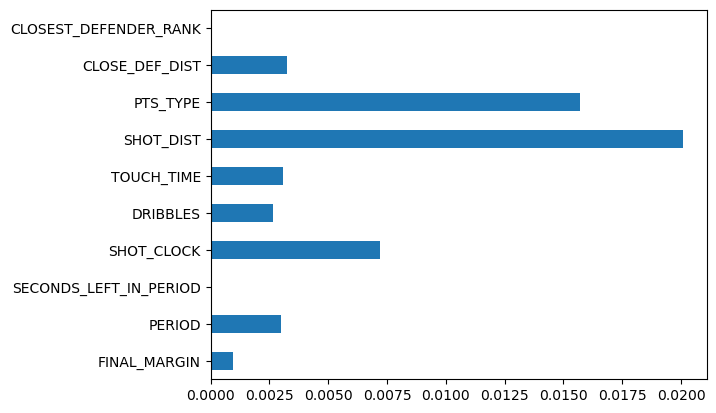

In [66]:
X = selected_features.drop('FGM', axis = 1)
y = selected_features['FGM']

importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, selected_features.columns[0:len(selected_features.columns)-1])
print(feat_importances)
feat_importances.plot(kind = 'barh')
plt.show()

<Axes: >

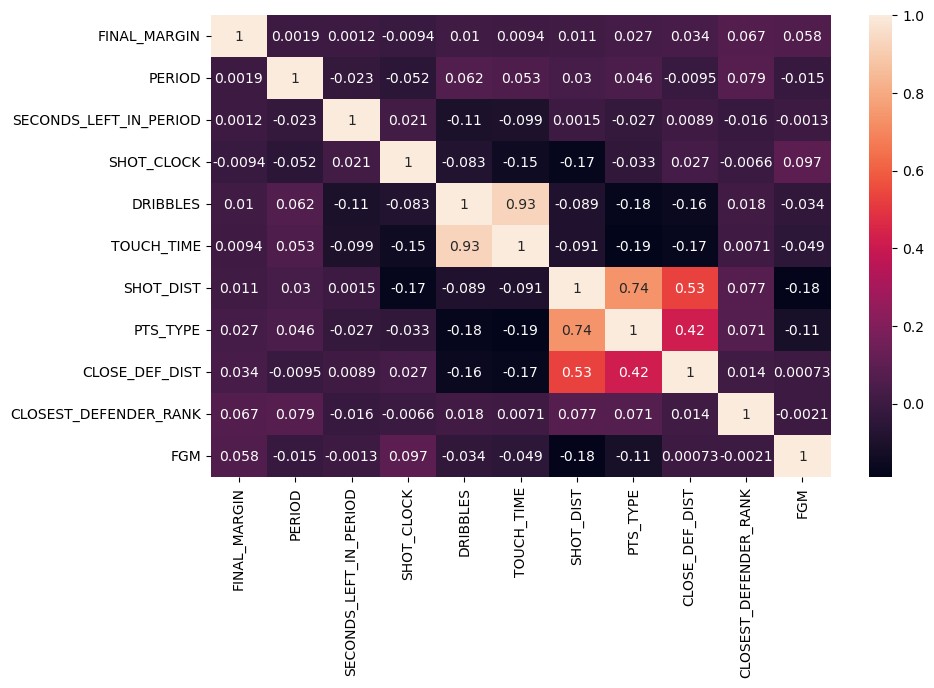

In [73]:
import seaborn as sns
cor = selected_features.corr()
plt.figure(figsize = (10,6))
sns.heatmap(cor, annot = True)

In [67]:
from sklearn.tree import DecisionTreeRegressor

In [68]:
X_DT = selected_features.drop('FGM', axis = 1)
y_DT = selected_features['FGM']
X_DT_train, X_DT_val, y_DT_train, y_DT_val = train_test_split(X_DT, y_DT, test_size = 0.2, random_state = 0)

In [69]:
modelDT = DecisionTreeRegressor(random_state=0)
modelDT.fit(X_DT_train, y_DT_train)

DecisionTreeRegressor(random_state=0)

In [70]:
importanceDT = modelDT.feature_importances_

In [81]:
DT_impt = pd.Series(importanceDT, selected_features.columns[0:len(selected_features.columns)-1])
# DT_impt = pd.DataFrame({"Features": X_DT_train.columns, "Value": importanceDT})
DT_impt = DT_impt.sort_values(ascending = False)
print(DT_impt)

SHOT_DIST                 0.161748
SECONDS_LEFT_IN_PERIOD    0.153191
CLOSEST_DEFENDER_RANK     0.149927
SHOT_CLOCK                0.135135
CLOSE_DEF_DIST            0.123133
FINAL_MARGIN              0.101965
TOUCH_TIME                0.100681
PERIOD                    0.038329
DRIBBLES                  0.034100
PTS_TYPE                  0.001792
dtype: float64


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

C:\Users\madha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic: f1=0.523 auc=0.603


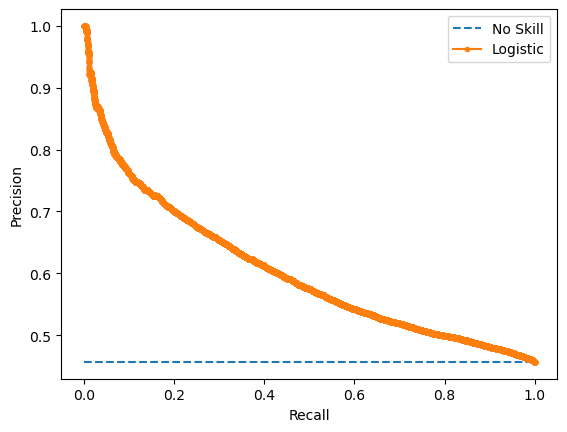

In [89]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
modelA = LogisticRegression(solver='lbfgs')
modelA.fit(trainX, trainy)
# predict probabilities
lr_probs = modelA.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = modelA.predict(testX)
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
# calculate scores
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [97]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (C:\Users\madha\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [99]:
fpr, tpr, thresholds = metrics.roc_curve(testy, yhat)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(testy, yhat))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

[0.         0.47434795 1.        ]
[0.         0.28617053 1.        ]
[2 1 0]
0.5940887087045232
Threshold value is: 1


In [101]:
x1 = df[['DRIBBLES']]
y1 = df[['FGM']]
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2)

In [102]:
from sklearn.linear_model import LogisticRegression

In [103]:
logmodel = LogisticRegression()

In [104]:
logmodel.fit(X1_train, y1_train)

C:\Users\madha\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [106]:
predictions1 = logmodel.predict(X1_test)

In [108]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, predictions1, pos_label=1)

In [109]:
thresholds1

array([1, 0], dtype=int64)

In [110]:
x2 = df[['CLOSE_DEF_DIST']]
y2 = df[['FGM']]
X2_train, X2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2)

In [111]:
from sklearn.linear_model import LogisticRegression

In [112]:
logmodel = LogisticRegression()

In [113]:
logmodel.fit(X2_train, y2_train)

C:\Users\madha\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [114]:
predictions2 = logmodel.predict(X2_test)

In [115]:
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, predictions2, pos_label=1)

In [117]:
thresholds2

array([1, 0], dtype=int64)

##Random Forest

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
X_RF = selected_features.drop('FGM', axis = 1)
y_RF = selected_features['FGM']
X_RF_train, X_RF_val, y_RF_train, y_RF_val = train_test_split(X_RF, y_RF, test_size = 0.2, random_state = 0)

In [78]:
modelRF = RandomForestRegressor(random_state=0)
modelRF.fit(X_RF_train, y_RF_train)

RandomForestRegressor(random_state=0)

In [79]:
importanceRF = modelRF.feature_importances_

In [80]:
RF_impt = pd.DataFrame({"Features": X_RF_train.columns, "Value": importanceRF})
RF_impt = RF_impt.sort_values(by = 'Value', ascending = False)
print(RF_impt)

                 Features     Value
6               SHOT_DIST  0.162542
2  SECONDS_LEFT_IN_PERIOD  0.152321
9   CLOSEST_DEFENDER_RANK  0.144080
3              SHOT_CLOCK  0.135916
8          CLOSE_DEF_DIST  0.122977
0            FINAL_MARGIN  0.103742
5              TOUCH_TIME  0.103042
1                  PERIOD  0.039118
4                DRIBBLES  0.034001
7                PTS_TYPE  0.002262


#Getting average importance of each feature

avgShotDistance = (RF_impt[RF_impt.Features == 'SHOT_DIST'].Value + DT_impt[DT_impt.Features == 'SHOT_DIST'].Value)/2
avgSecondsLeft = (RF_impt[RF_impt.Features == 'SECONDS_LEFT_IN_PERIOD'].Value + DT_impt[DT_impt.Features == 'SECONDS_LEFT_IN_PERIOD'].Value)/2
avgClosestDfRank = (RF_impt[RF_impt.Features == 'CLOSEST_DEFENDER_RANK'].Value + DT_impt[DT_impt.Features == 'CLOSEST_DEFENDER_RANK'].Value)/2
avgShotClock = (RF_impt[RF_impt.Features == 'SHOT_CLOCK'].Value + DT_impt[DT_impt.Features == 'SHOT_CLOCK'].Value)/2
avgClosestDFDist = (RF_impt[RF_impt.Features == 'CLOSE_DEF_DIST'].Value + DT_impt[DT_impt.Features == 'CLOSE_DEF_DIST'].Value)/2
avgFinalMargin = (RF_impt[RF_impt.Features == 'FINAL_MARGIN'].Value + DT_impt[DT_impt.Features == 'FINAL_MARGIN'].Value)/2
avgTouchTime = (RF_impt[RF_impt.Features == 'TOUCH_TIME'].Value + DT_impt[DT_impt.Features == 'TOUCH_TIME'].Value)/2
avgPeriod = (RF_impt[RF_impt.Features == 'PERIOD'].Value + DT_impt[DT_impt.Features == 'PERIOD'].Value)/2
avgDribbles = (RF_impt[RF_impt.Features == 'DRIBBLES'].Value + DT_impt[DT_impt.Features == 'DRIBBLES'].Value)/2
avgPtsType = (RF_impt[RF_impt.Features == 'PTS_TYPE'].Value + DT_impt[DT_impt.Features == 'PTS_TYPE'].Value)/2

print(avgClosestDfRank)

zx = df['player_id']
zx = pd.Series.to_frame(zx)
for i in df['player_id']:
    tp = df[df['player_id'] == i]
    zx.loc[zx['player_id'] == i, 'SHOT_DIST'] = tp['SHOT_DIST'].mean()
  zx.loc[zx['player_id'] == i, 'SECONDS_LEFT_IN_PERIOD'] = tp['SECONDS_LEFT_IN_PERIOD'].mean()
  zx.loc[zx['player_id'] == i, 'CLOSEST_DEFENDER_RANK'] = tp['CLOSEST_DEFENDER_RANK'].mean()
  zx.loc[zx['player_id'] == i, 'SHOT_CLOCK'] = tp['SHOT_CLOCK'].mean()
  zx.loc[zx['player_id'] == i, 'CLOSE_DEF_DIST'] = tp['CLOSE_DEF_DIST'].mean()
  zx.loc[zx['player_id'] == i, 'FINAL_MARGIN'] = tp['FINAL_MARGIN'].mean()
  zx.loc[zx['player_id'] == i, 'TOUCH_TIME'] = tp['TOUCH_TIME'].mean()
  zx.loc[zx['player_id'] == i, 'PERIOD'] = tp['PERIOD'].mean()
  zx.loc[zx['player_id'] == i, 'DRIBBLES'] = tp['DRIBBLES'].mean()
  zx.loc[zx['player_id'] == i, 'PTS_TYPE'] = tp['PTS_TYPE'].mean()


zx = zx.drop_duplicates()

zx

for player in zx['player_id']:
    temp_df = zx[zx['player_id'] == player]
    a = avgShotDistance * temp_df.SHOT_DIST.iloc[0]
    b = temp_df['SECONDS_LEFT_IN_PERIOD'].iloc[0] * avgSecondsLeft
    c = temp_df['CLOSEST_DEFENDER_RANK'].iloc[0] *avgClosestDfRank
    d = temp_df['SHOT_CLOCK'].iloc[0] *avgShotClock
    e = temp_df['CLOSE_DEF_DIST'].iloc[0] *avgClosestDFDist
    f = temp_df['FINAL_MARGIN'].iloc[0] *avgFinalMargin
    g = temp_df['TOUCH_TIME'].iloc[0] *avgTouchTime
    h = temp_df['PERIOD'].iloc[0] *avgPeriod
    i = temp_df['DRIBBLES'].iloc[0] *avgDribbles
    j = temp_df['PTS_TYPE'].iloc[0] *avgPtsType
    temp_eff = a.iloc[0] + b.iloc[0] + c.iloc[0] + d.iloc[0] + e.iloc[0] + f.iloc[0] + g.iloc[0] + h.iloc[0] + i.iloc[0] + j.iloc[0]
    zx.loc[(zx['player_id'] == player), 'Eff'] = temp_eff
    


zx['PLAYER_RANK'] = zx[['Eff']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

player_shooting_eff = pd.DataFrame({'Player_ID' : zx['player_id'], 'Rank' : zx['PLAYER_RANK']})
player_shooting_eff.sort_values(by = 'Rank',ascending = True)

df[df['player_id'] == 200770]

## Clustering

In [119]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[['SHOT_DIST', 'CLOSE_DEF_DIST']])

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['FGM'])
plt.show()

C:\Users\madha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyError: 'dribbles'

In [51]:
df['SD_CDD_LABELS'] = kmeans.labels_
centroids  = kmeans.cluster_centers_
for label in range(0, 2):
    samplesCentroids = centroids[label]
    print(samplesCentroids)
    #print(label, float(sum(df[df['SD_CDD_LABELS'] == label]['SHOT_RESULT_BINARY'])) / float(len(df[df['SD_CDD_LABELS'] == label]['SHOT_RESULT_BINARY'])))

[21.53075915  5.55886054]
[5.38667408 2.69022134]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


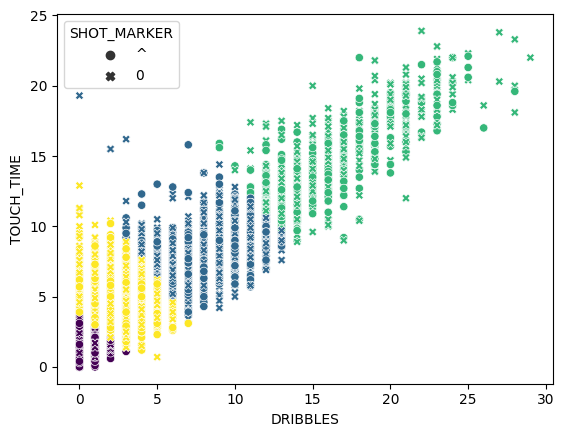

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['DRIBBLES', 'TOUCH_TIME']])

sns.scatterplot(x=df['DRIBBLES'], y=df['TOUCH_TIME'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['D_TT_LABELS'] = kmeans.labels_
for label in range(0, 4):
  print(label, float(sum(df[df['D_TT_LABELS'] == label]['SHOT_RESULT_BINARY'])) / float(len(df[df['D_TT_LABELS'] == label]['SHOT_RESULT_BINARY'])))

0 0.4810582977859029
1 0.4241883696039957
2 0.38742138364779877
3 0.43438796680497926


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


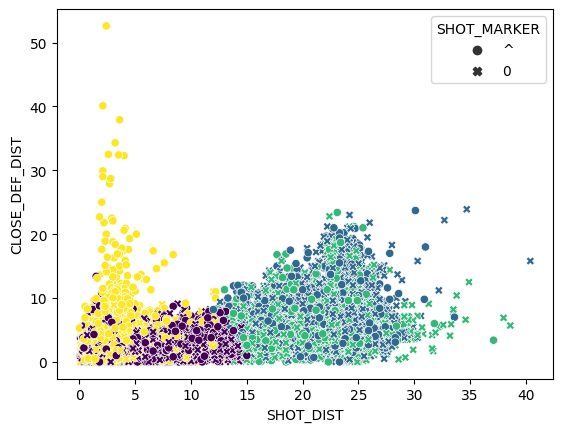

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['SHOT_DIST', 'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'PTS_TYPE', 'CLOSEST_DEFENDER_EFFICIENCY']])

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['FULL_CONDITIONS_LABELS'] = kmeans.labels_
for label in range(0, 4):
  print(label, float(sum(df[df['FULL_CONDITIONS_LABELS'] == label]['SHOT_RESULT_BINARY'])) / float(len(df[df['FULL_CONDITIONS_LABELS'] == label]['SHOT_RESULT_BINARY'])))

0 0.48568892833370314
1 0.39970171513795677
2 0.37195532229847933
3 0.6085086776224851


In [ ]:
df[['SHOT_DIST', 'FULL_CONDITIONS_LABELS']].sort_values('SHOT_DIST', ascending=False).head()

,SHOT_DIST,FULL_CONDITIONS_LABELS
3307,40.4,1
9949,38.6,2
7181,38.0,2
12799,37.1,2
19909,34.9,2


In [ ]:
df[['CLOSE_DEF_DIST', 'FULL_CONDITIONS_LABELS']].sort_values('CLOSE_DEF_DIST', ascending=False).head()

,CLOSE_DEF_DIST,FULL_CONDITIONS_LABELS
4877,52.6,3
15383,40.1,3
21524,37.9,3
31146,34.3,3
17604,32.5,3
